# Convolutional Layers

### Implementing convolutional layers with keras

In [1]:

import sys

assert sys.version_info >= (3, 7)

In [2]:
import tensorflow as tf
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

In [3]:
if tf.config.list_physical_devices('GPU'):
  print("Connected to GPU successfully!")
else:
  print("No GPU connnected")

Connected to GPU successfully!


In [4]:
images=load_sample_images()["images"]
images=tf.keras.layers.CenterCrop(height=75,width=115)(images)
images=tf.keras.layers.Rescaling(scale=1/255)(images)

In [5]:
images.shape

TensorShape([2, 75, 115, 3])

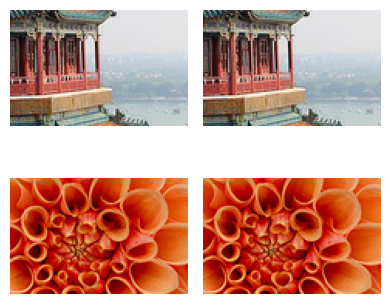

In [6]:
plt.figure(figsize=(4,4))
for img_idx in (0,1):
    for j in (0,1):
        plt.subplot(2,2,img_idx*2+j+1)
        plt.imshow(images[img_idx,:,:,:])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
tf.keras.utils.set_random_seed(42)

conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=8)
fmap=conv_layer(images)

In [8]:
fmap.shape

TensorShape([2, 68, 108, 32])

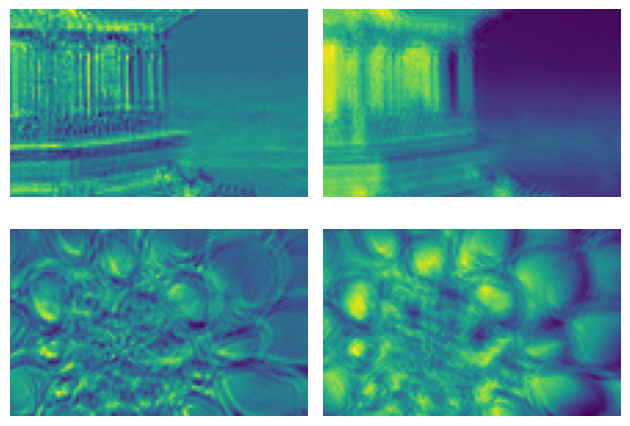

In [10]:
for img_idx in (0,1):
    for fmap_idx in (0,1):
        plt.subplot(2,2,img_idx*2+fmap_idx+1)
        plt.imshow(fmap[img_idx,:,:,fmap_idx])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding="same")
fmap=conv_layer(images)

In [12]:
fmap.shape

TensorShape([2, 75, 115, 32])

In [13]:
conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding="same",
                                 strides=2)
fmap=conv_layer(images)
fmap.shape

TensorShape([2, 38, 58, 32])

In [14]:
kernel,biases=conv_layer.get_weights()

In [15]:
kernel.shape

(7, 7, 3, 32)

In [16]:
biases.shape

(32,)

In [17]:
filters=tf.random.normal([7,7,3,2])
biases=tf.zeros([2])
fmaps=tf.nn.conv2d(images,filters,strides=1,padding="SAME")+biases

In [18]:
fmaps.shape

TensorShape([2, 75, 115, 2])

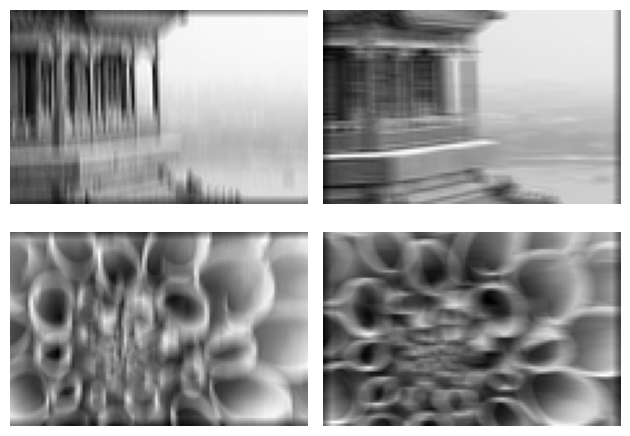

In [19]:
import numpy as np

filters=np.zeros([7,7,3,2])
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1
fmaps=tf.nn.conv2d(images,filters,strides=1,padding="SAME")+biases

for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2,image_idx*2+fmap_idx+1)
    plt.imshow(fmaps[image_idx,:,:,fmap_idx],cmap="gray")
    plt.axis("off")
plt.tight_layout()


# Pooling Layers


### Max pooling


In [21]:
max_pool=tf.keras.layers.MaxPool2D(pool_size=2)

In [24]:
output=max_pool(images)

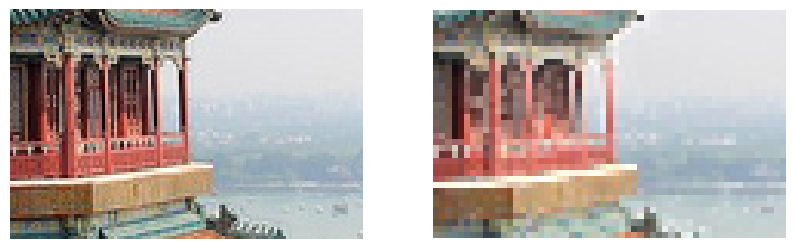

In [25]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(output[0])
plt.axis("off")
plt.show()


##### Depth-wise pooling

In [27]:
class DepthPool(tf.keras.layers.Layer):
  def __init__(self,pool_size=2,**kwargs):
    super().__init__(**kwargs)
    self.pool_size=pool_size

  def call(self,inputs):
    shape=tf.shape(inputs)
    groups=shape[-1]//self.pool_size
    new_shape=tf.concat([shape[:-1],[groups,self.pool_size]],axis=0)
    return tf.reduce_max(tf.reshape(inputs,new_shape),axis=-1)    #So for every [batch, height, width, group], it
                                                                    #looks at the 3 values in that group and picks the maximum.




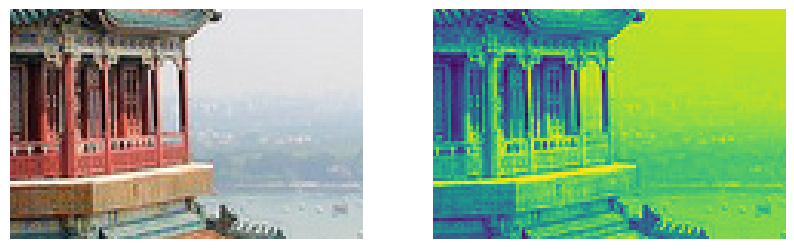

In [ ]:
depth_output=DepthPool(pool_size=3)(images)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)

plt.imshow(images[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(depth_output[0])
plt.axis("off")
plt.show()

##### Global Average Pooling

In [28]:
global_avg_pooling=tf.keras.layers.GlobalAveragePooling2D()

In [29]:
global_avg_pooling=tf.keras.layers.Lambda(lambda X:tf.reduce_mean(X,axis=[1,2]))

# CNN Architectures

###### Tackling Fashion MNIST With a CNN

In [30]:
mnist=tf.keras.datasets.fashion_mnist.load_data()
(X_train_full,y_train_full),(X_test,y_test)=mnist
X_train_full=np.expand_dims(X_train_full,axis=-1).astype(np.float32)/255
X_test=np.expand_dims(X_test,axis=-1).astype(np.float32)/255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [31]:
from functools import partial

DefaultConv2D=partial(tf.keras.layers.Conv2D,kernel_size=3,padding="same",activation="relu",
                      kernel_initializer="he_normal")

model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[28,28,1]),
    DefaultConv2D(filters=64,kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation="softmax")


])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",
              metrics=["accuracy"])
model.fit(X_train,y_train,
          epochs=10,
          validation_data=(X_valid,y_valid))
score=model.evaluate(X_test,y_test)
X_new=X_test[:10]
model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.5776 - loss: 1.1775 - val_accuracy: 0.8622 - val_loss: 0.3925
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8374 - loss: 0.4822 - val_accuracy: 0.8812 - val_loss: 0.3426
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8670 - loss: 0.3898 - val_accuracy: 0.8994 - val_loss: 0.2732
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8858 - loss: 0.3351 - val_accuracy: 0.8966 - val_loss: 0.2970
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8961 - loss: 0.3051 - val_accuracy: 0.8906 - val_loss: 0.3022
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9045 - loss: 0.2839 - val_accuracy: 0.8990 - val_loss: 0.2921
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9119 - loss: 0.2625 - val_accuracy: 0.9070 - val_loss: 0.2653
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9164 - loss: 

array([[4.2299914e-37, 1.8945555e-42, 1.4694560e-36, 9.1364660e-42,
        2.5689579e-38, 9.3169287e-14, 1.7623101e-34, 3.6711392e-09,
        3.3463688e-27, 1.0000000e+00],
       [7.4189275e-12, 6.8694753e-28, 9.9999321e-01, 2.0387955e-19,
        9.5448396e-09, 1.1851291e-27, 6.7829119e-06, 1.5999613e-37,
        1.9082316e-21, 2.8101106e-36],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 5.6051939e-45,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6754373e-03, 1.2191969e-11, 7.2927505e-04, 3.8513854e-06,
        2.0223339e-03, 9.4767783e-10, 9.9556917e-01, 4.5951079e-10,
        5.0842409e-08, 1.4081333e-09],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 3.2201839e-42,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.00

## GoogLeNet

In [33]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model

def InceptionModule(x,f1,f3r,f3,f5r,f5,proj):

  path1=Conv2D(f1,kernel_size=1,padding="same",activation="relu")(x)

  path2=Conv2D(f3r,kernel_size=1,padding="same",activation="relu")(x)
  path2=Conv2D(f3,kernel_size=3,padding="same",activation="relu")(path2)

  path3=Conv2D(f5r,kernel_size=1,padding="same",activation="relu")(x)
  path3=Conv2D(f5,kernel_size=5,padding="same",activation="relu")(path3)

  path4=MaxPooling2D(pool_size=3,strides=1,padding="same")(x)
  path4=Conv2D(proj,kernel_size=1,padding="same",activation="relu")(path4)

  return Concatenate(axis=-1)([path1,path2,path3,path4])

In [34]:
from tensorflow.keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Activation,Input,Dropout

input_layer=Input(shape=(28,28,1))

x=Conv2D(filters=64,kernel_size=7,strides=2,padding="same",activation="relu")(input_layer)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)
x=BatchNormalization()(x)

x=Conv2D(64,kernel_size=1,padding="same",activation="relu")(x)
x=Conv2D(192,kernel_size=3,padding="same",activation="relu")(x)
x=BatchNormalization()(x)
x=Activation("relu")(x)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,64,96,128,12,32,32)
x=InceptionModule(x,128,128,192,32,96,64)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,192, 96, 208, 16, 48, 64)
x=InceptionModule(x,160, 112, 224, 24, 64, 64)
x=InceptionModule(x, 128, 128, 256, 24, 64, 64)
x=InceptionModule(x,112, 144, 288, 32, 64, 64)
x=InceptionModule(x,256, 160, 320, 32, 128, 128)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,256, 160, 320, 32, 128, 128)
x=InceptionModule(x,384, 192, 384, 48, 128, 128)
x=GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x=Dense(10,activation="softmax")(x)


model=Model(input_layer,x)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │      3,200 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 7, 7, 64)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7, 64)  │        256 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 64)  │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 7, 7, 192) │    110,784 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 192) │        768 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 7, 7, 192) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 4, 4, 192) │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 4, 4, 96)  │     18,528 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 4, 4, 12)  │      2,316 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 4, 4, 192) │          0 │ max_pooling2d_6[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 64)  │     12,352 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 4, 4, 128) │    110,720 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 4, 4, 32)  │      9,632 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 4, 4, 32)  │      6,176 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 256) │          0 │ conv2d_11[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_13[0][0],  │
│                     │                   │            │ conv2d_15[0][0],  │
│                     │                   │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 4, 4, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 4, 4, 32)  │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,974,582 (22.79 MB)

 Trainable params: 5,974,070 (22.79 MB)

 Non-trainable params: 512 (2.00 KB)

In [35]:

model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",
              metrics=["accuracy"])
model.fit(X_train,y_train,
          epochs=10,
          validation_data=(X_valid,y_valid))
score=model.evaluate(X_test,y_test)
X_new=X_test[:10]
model.predict(X_new)

Epoch 1/10


KeyboardInterrupt: 

## ResNet-34

In [36]:
DefaultConv2D=partial(tf.keras.layers.Conv2D,kernel_size=3,strides=1,padding="same",
                      kernel_initializer="he_normal",use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self,filters,strides=1,activation="relu",**kwargs):
     super().__init__(**kwargs)
     self.activation=tf.keras.activations.get(activation)
     self.main_layers=[
         DefaultConv2D(filters,strides=strides),
         tf.keras.layers.BatchNormalization(),
         self.activation,
         DefaultConv2D(filters),
         tf.keras.layers.BatchNormalization()
     ]
     self.skip_layers=[]
     if strides>1:
      self.skip_layers=[
          DefaultConv2D(filters,kernel_size=1,strides=strides),
          tf.keras.layers.BatchNormalization()
      ]

  def call(self,inputs):
    Z=inputs
    for layer in self.main_layers:
      Z=layer(Z)
    skip_Z=inputs
    for layer in self.skip_layers:
      skip_Z=layer(skip_Z)

    return self.activation(Z+skip_Z)

In [37]:
mean=np.mean(X_train_full,axis=(0,1,2))
std=np.std(X_train_full,axis=(0,1,2))

data_preprocessing=tf.keras.Sequential([
    tf.keras.layers.Normalization(mean=mean.tolist(),variance=(std**2).tolist()),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [38]:
model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[32,32,3]),
    data_preprocessing,
    DefaultConv2D(64,kernel_size=3,strides=1,padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    # tf.keras.layers.MaxPooling2D(pool_size=3,strides=2),
])

prev_filter=64
for filters in [64]*3 +[128]*4 + [256]*6 + [512]*3:
  strides = 1 if filters==prev_filter else 2
  model.add(ResidualUnit(filters=filters,strides=strides))
  prev_filter=filters

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(100,activation="softmax"))



In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 16, 16, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 8, 8, 256)      │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 4, 4, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 4, 4, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 4, 4, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,345,316 (81.43 MB)

 Trainable params: 21,328,292 (81.36 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
X_train_full = X_train_full.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
X_train,y_train=X_train_full[5000:],y_train_full[5000:]
X_valid,y_valid=X_train_full[:5000],y_train_full[:5000]

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


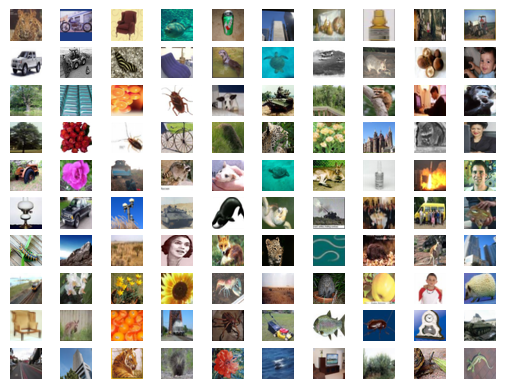

In [ ]:
import matplotlib.pyplot as plt
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()


In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history=model.fit(X_train,y_train,
                  epochs=10,
                  validation_data=(X_valid,y_valid))

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 174s 106ms/step - accuracy: 0.0922 - loss: 4.0961 - val_accuracy: 0.1200 - val_loss: 4.2430
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 149s 106ms/step - accuracy: 0.2086 - loss: 3.2369 - val_accuracy: 0.1904 - val_loss: 3.8010
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 202s 106ms/step - accuracy: 0.2827 - loss: 2.8410 - val_accuracy: 0.2556 - val_loss: 3.1917
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 200s 105ms/step - accuracy: 0.3463 - loss: 2.5280 - val_accuracy: 0.2688 - val_loss: 3.1950
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 148s 105ms/step - accuracy: 0.3967 - loss: 2.2898 - val_accuracy: 0.2918 - val_loss: 3.1922
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 147s 104ms/step - accuracy: 0.4424 - loss: 2.0807 - val_accuracy: 0.2892 - val_loss: 3.3460
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 202s 105ms/step - accuracy: 0.4802 - loss: 1.9100 - val_accuracy: 0.3022 - val_loss: 3.3937
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 204s 106ms/step - ac

In [ ]:
model.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3334 - loss: 3.6390


[3.6349730491638184, 0.3337000012397766]

## Using Pretrained Modes from Keras

In [ ]:
model=tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
images=tf.constant(load_sample_images()["images"])
images_resized=tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True)(images)

In [ ]:
images.shape

TensorShape([2, 427, 640, 3])

In [ ]:
images_resized.shape

TensorShape([2, 224, 224, 3])

In [ ]:
inputs=tf.keras.applications.resnet50.preprocess_input(images_resized)
y_proba=model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [ ]:
y_proba.shape

(2, 1000)

In [ ]:
top_K=tf.keras.applications.resnet50.decode_predictions(y_proba,top=5)

for idx in range(len(images)):
  print(f"Image #{idx}")
  for class_id,name,y_proba in top_K[idx]:
    print(f"{class_id}-{name:12s} {y_proba:.2%}")

Image #0
n03877845-palace       54.83%
n03781244-monastery    24.40%
n02825657-bell_cote    18.74%
n02980441-castle       0.78%
n04346328-stupa        0.34%
Image #1
n04522168-vase         32.17%
n11939491-daisy        17.87%
n03530642-honeycomb    12.03%
n13040303-stinkhorn    4.49%
n07930864-cup          4.19%


# Pretrained Models for Transfer Learning

In [85]:
import tensorflow_datasets as tfds

dataset,info=tfds.load("tf_flowers",as_supervised=True,with_info=True)
dataset_size=info.splits["train"].num_examples
class_names=info.features["label"].names
num_classes=info.features["label"].num_classes

In [86]:


test_set_raw,valid_set_raw,train_set_raw=tfds.load(
    "tf_flowers",
    split=["train[:10%]","train[10%:25%]","train[25%:]"],
    as_supervised=True,

    )

In [45]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [46]:
dataset_size

3670

In [47]:
num_classes

5

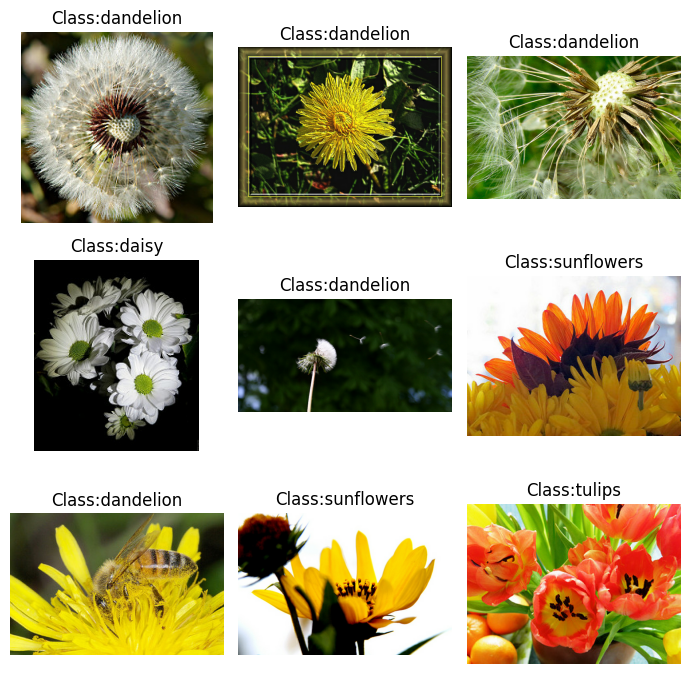

In [87]:
plt.figure(figsize=(7,7))
idx=0
for image,label in train_set_raw.take(9):
  idx+=1
  plt.subplot(3,3,idx)
  plt.imshow(image)
  plt.title(f"Class:{class_names[label]}")
  plt.axis("off")
plt.tight_layout()
plt.show()

In [88]:
tf.keras.backend.clear_session()

In [110]:
batch_size=32
preprocess=tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set=train_set_raw.map(lambda X,y: (preprocess(X),y))
train_set=train_set.shuffle(1000,seed=42).batch(batch_size).prefetch(1)
valid_set=valid_set_raw.map(lambda X,y:(preprocess(X),y)).batch(batch_size)
test_set=test_set_raw.map(lambda X,y:(preprocess(X),y)).batch(batch_size)

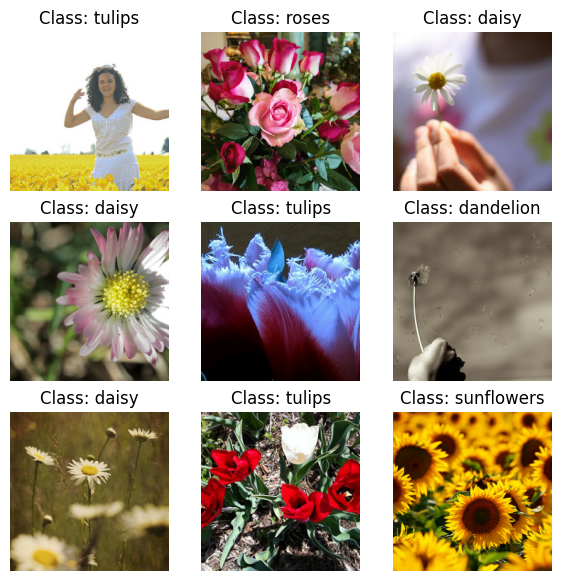

In [111]:
plt.figure(figsize=(7,7))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()


In [126]:
data_agumentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal",seed=42),
    tf.keras.layers.RandomRotation(0.05,seed=42),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])


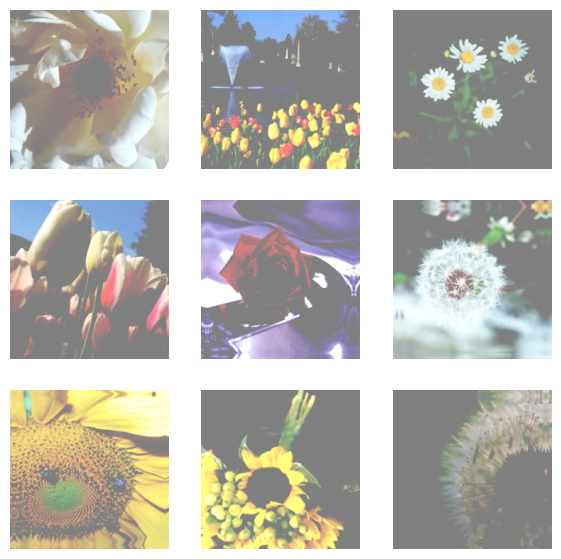

In [127]:
plt.figure(figsize=(7,7))
for X_batch,y_batch in train_set.take(1):
  X_batch_agumentation=data_agumentation(X_batch,training=True)
  for idx in range(9):
    plt.subplot(3,3,idx+1)
    plt.imshow(np.clip((X_batch_agumentation[idx]+1)/2,0,1))
    plt.axis("off")
plt.show()

In [129]:
tf.random.set_seed(42)

base_model=tf.keras.applications.xception.Xception(weights="imagenet",
                                                   include_top=False)
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(num_classes,activation="softmax")(avg)
model=tf.keras.Model(inputs=base_model.inputs,outputs=output)

In [130]:
for layer in base_model.layers:
  layer.trainable=False

In [131]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])
history=model.fit(train_set,
                  epochs=3,
                  validation_data=(valid_set))


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_187']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


86/86 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step - accuracy: 0.6763 - loss: 6.1374 - val_accuracy: 0.8421 - val_loss: 2.9815
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.8969 - loss: 1.2943 - val_accuracy: 0.8330 - val_loss: 3.6747
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.9169 - loss: 0.8463 - val_accuracy: 0.8566 - val_loss: 2.6201


In [140]:
for indices in zip(range(33),range(33,66),range(66,99),range(99,132)):
  for idx in indices:
    print(f"{idx:3}: {base_model.layers[idx].name:22}",end="")
  print()

  0: input_layer_14         33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_6  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_14                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_21                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [141]:
for layer in base_model.layers[56:]:
  layer.trainable=True

In [142]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])

history=model.fit(train_set,
                  epochs=10,
                  validation_data=(valid_set))


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 352ms/step - accuracy: 0.5465 - loss: 1.5694 - val_accuracy: 0.2613 - val_loss: 53060.2812
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.7731 - loss: 0.8272 - val_accuracy: 0.5408 - val_loss: 24.0841
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 296ms/step - accuracy: 0.8138 - loss: 0.5571 - val_accuracy: 0.7078 - val_loss: 5.2432
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step - accuracy: 0.8735 - loss: 0.3474 - val_accuracy: 0.5699 - val_loss: 3.9350
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.8741 - loss: 0.3937 - val_accuracy: 0.1797 - val_loss: 1233035.7500
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.8530 - loss: 0.4534 - val_accuracy: 0.2740 - val_loss: 84.6701
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.8827 - loss: 0.3752 - val_accuracy: 0.1706 - val_loss: 202.5164
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.7405 - loss: 2.3